In [34]:
import os
import torch
import glob
import timm
import cv2
import pydicom
import numpy as np
from PIL import Image


## Load the model for prediction

In [35]:
def load_weights_skip_mismatch(model, weights_path, device):
    state_dict = torch.load(weights_path, map_location=device,weights_only=False)
    model_state_dict = model.state_dict()
    new_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}
    model_state_dict.update(new_state_dict)
    model.load_state_dict(model_state_dict)

In [36]:
model = timm.create_model('resnet18', pretrained=True, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
weights_path = r'E:\CodeSpace\Major Project\resnet18.pt'
load_weights_skip_mismatch(model, weights_path, device)

## Take Image input as .dcm format and save as .png

In [51]:
def convert_dcm_to_png_sagittal(dcm_file_path, output_folder):
    # Load the DICOM file
    dicom_data = pydicom.dcmread(dcm_file_path)
    pixel_array = dicom_data.pixel_array

    # Handle 2D and 3D data cases
    if len(pixel_array.shape) == 3:
        slices, rows, cols = pixel_array.shape
    elif len(pixel_array.shape) == 2:
        rows, cols = pixel_array.shape
        slices = 1
        pixel_array = pixel_array[np.newaxis, :, :]  # Add a new axis for consistency
    else:
        raise ValueError("Unexpected DICOM data shape. Only 2D or 3D images are supported.")
    
    # Normalize pixel values to the range [0, 255] without distortion
    pixel_array = pixel_array.astype(np.float32)  # Convert to float for normalization
    pixel_array = (pixel_array - pixel_array.min()) / (pixel_array.max() - pixel_array.min()) * 255
    pixel_array = pixel_array.astype(np.uint8)  # Convert back to uint8

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    saved_image_paths = []  # List to store paths of saved images

    # Convert each slice to a PNG
    for i in range(slices):
        img = Image.fromarray(pixel_array[i])  # Convert the array to an image
        image_path = os.path.join(output_folder, f'slice_{i}.png')
        img.save(image_path)
        saved_image_paths.append(image_path)

    return saved_image_paths  # Return the paths of saved images


In [52]:
def create_folder_based_on_input(input_file, base_path=r'E:\CodeSpace\Major Project\temp'):
    file_name = os.path.splitext(os.path.basename(input_file))[0]
    dynamic_folder = os.path.join(base_path, f'{file_name}_output')
    os.makedirs(dynamic_folder, exist_ok=True)
    return dynamic_folder

In [53]:
dcm_image_path = r"E:\CodeSpace\Major Project\RSNA Lumber Spine Dataset\44036939\2828203845\10.dcm"
output_image_path = create_folder_based_on_input(dcm_image_path)

In [59]:
png_image_path = convert_dcm_to_png_sagittal(dcm_image_path, output_image_path)
png_image_path

['E:\\CodeSpace\\Major Project\\temp\\10_output\\slice_0.png']

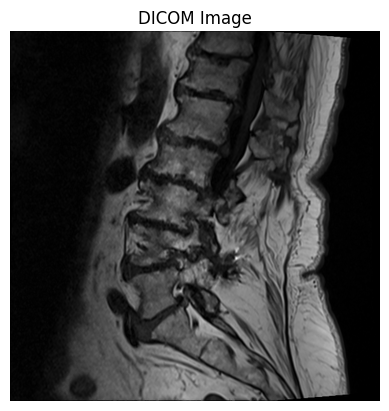

In [60]:
# Load the DICOM file
import matplotlib.pyplot as plt

dicom_data = pydicom.dcmread(dcm_image_path)
pixel_array = dicom_data.pixel_array

# Plot the image
plt.imshow(pixel_array, cmap=plt.gray())  # Display the image in grayscale
plt.title('DICOM Image')
plt.axis('off')  # Optional: Remove axes for a cleaner look
plt.show()

## Make predictions from jpg image

In [67]:
def predict(image_path, model, device, target_size=(256, 256)):
    """
    Predict the output for a single image using the model.
    Args:
        image_path (str): Path to the image file.
        model (torch.nn.Module): The trained model.
        device (torch.device): The device (CPU or GPU) to run the model on.
        target_size (tuple): Target size for resizing the image.
    Returns:
        np.ndarray: Model prediction.
    """
    # If image_path is a list, take the first element (assuming it's a single file)
    if isinstance(image_path, list):
        if len(image_path) == 0:
            print("Error: Provided list for image_path is empty.")
            return None
        image_path = image_path[0]  # Convert to string path

    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at path: {image_path}")
        return None
    
    # Resize, convert to RGB, and normalize
    image_resized = cv2.resize(image, target_size)
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image_transposed = np.transpose(image_rgb, (2, 0, 1)).astype(np.float32) / 255.0
    image_tensor = torch.tensor(image_transposed).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Set the model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        preds = model(image_tensor)
        preds = torch.sigmoid(preds)  # Apply sigmoid for probability outputs

    # Return the prediction (as numpy array)
    return preds.cpu().numpy()


In [68]:
print(png_image_path)

['E:\\CodeSpace\\Major Project\\temp\\10_output\\slice_0.png']


In [69]:
pred = predict(png_image_path, model, device)

In [70]:
print(pred)

[[0.5369197  0.36451364 0.5103523  0.4539871  0.4858879  0.5525081
  0.50637084 0.6090654  0.52802485 0.70542985]]


## Plot the prediction on the image

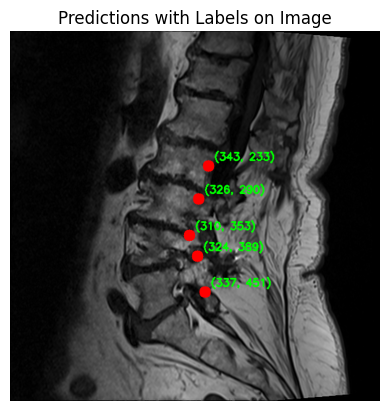

In [ ]:
def plot_predictions_with_labels(image_path, predictions, output_path=None):
    """
    Plot predictions (coordinates) on the given image with labels.
    Args:
        image_path (str): Path to the image file.
        predictions (list or np.ndarray): List/array of predictions (coordinates).
        output_path (str, optional): If provided, save the output image at this path.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at path: {image_path}")
        return

    # Convert image from BGR (OpenCV default) to RGB for display with Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Assume predictions are coordinates in the form [x1, y1, x2, y2, ...]
    for i in range(0, len(predictions[0]), 2):  # Step by 2 (x, y pairs)
        x = int(predictions[0][i] * image.shape[1])  # Scale coordinates to image width
        y = int(predictions[0][i + 1] * image.shape[0])  # Scale coordinates to image height
        
        # Draw a larger circle at the (x, y) coordinate
        cv2.circle(image_rgb, (x, y), radius=10, color=(255, 0, 0), thickness=-1)  # Red dot with larger radius

        # Add a label with the coordinates
        label = f"({x}, {y})"
        font_scale = 0.6
        thickness = 2
        cv2.putText(image_rgb, label, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)

    # Display the image with predictions and labels
    plt.imshow(image_rgb)
    plt.axis('off')  # Optional: Remove axis for cleaner display
    plt.title('Predictions with Labels on Image')
    plt.show()

    # Optionally save the image with predictions
    if output_path:
        image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)  # Convert back to BGR to save with OpenCV
        cv2.imwrite(output_path, image_bgr)



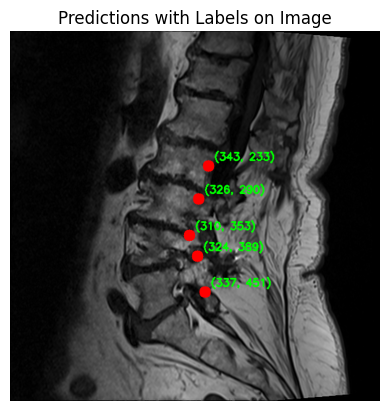

In [73]:
plot_predictions_with_labels('E:\\CodeSpace\\Major Project\\temp\\10_output\\slice_0.png', pred)